## Абруптивные, имплозивные и высота
Есть данные, что количество абруптивных зависит от высоты. Проверим это на датасетах из Phoible.

### 1. Получение данных

In [1]:
import lingtypology
from lingtypology.db_apis import Phoible
import pandas

Данные из UPSID (количество абруптивных и высота).

In [2]:
upsid = Phoible(subset='UPSID', aggregated=False).get_df()

Moran, Steven & McCloy, Daniel (eds.) 2019.
PHOIBLE 2.0.
Jena: Max Planck Institute for the Science of Human History.
(Available online at http://phoible.org, Accessed on 2019-05-19.)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [3]:
amount_of_ejectives = upsid[upsid.raisedLarynxEjective == '+'].groupby('Glottocode').size()
amount_of_ejectives.head()

Glottocode
afad1236     4
ahte1237     4
amha1245     5
arch1244    15
avar1256     9
dtype: int64

Высота.

In [4]:
languages = [lingtypology.glottolog.get_by_glot_id(glot_id) \
             for glot_id in amount_of_ejectives.index]
upsid_ejectives = pandas.DataFrame({
    'language': languages,
    'ejectives': amount_of_ejectives,
    'elevation': lingtypology.get_elevations(languages),
})
upsid_ejectives.head()

,language,ejectives,elevation
Glottocode,,,
afad1236,Afade,4,293
ahte1237,Ahtena,4,0
amha1245,Amharic,5,3440
arch1244,Archi,15,1822
avar1256,Avar,9,646


Визуализация на карте.

In [5]:
m = lingtypology.LingMap(upsid_ejectives.language)
m.tiles = 'Stamen Terrain'
m.radius = 5
m.opacity = 0.5
m.colors = ('blue',)
m.add_tooltips(upsid_ejectives.elevation)
m.create_map()

Данные вместе языками, где нет абруптивных.

In [6]:
upsid_no_ejectives = upsid[~upsid.Glottocode.isin(list(amount_of_ejectives.index))]
upsid_no_ejectives = upsid_no_ejectives.drop_duplicates(subset='Glottocode')
languages = [lingtypology.glottolog.get_by_glot_id(glot_id) \
             for glot_id in upsid_no_ejectives.Glottocode]
upsid_no_ejectives = pandas.DataFrame({
    'language': languages,
    'ejectives': 0,
    'elevation': lingtypology.get_elevations(languages),
})
upsid_ejectives_with_zeros = pandas.concat((upsid_ejectives, upsid_no_ejectives))
upsid_ejectives_with_zeros.head()

,language,ejectives,elevation
afad1236,Afade,4,293
ahte1237,Ahtena,4,0
amha1245,Amharic,5,3440
arch1244,Archi,15,1822
avar1256,Avar,9,646


## 2. Линейная регрессия

In [7]:
from scipy.stats import linregress
#from sklearn.preprocessing import StandardScaler

regr = linregress(upsid_ejectives.ejectives, upsid_ejectives.elevation)
regr
#scaled = StandardScaler().fit_transform(upsid_ejectives[['ejectives', 'elevation']])
#scaled
#regr = linregress(scaled)
#regr

LinregressResult(slope=2.671052631578945, intercept=1002.5017162471396, rvalue=0.00760325683990395, pvalue=0.9505592829934656, stderr=42.91734323215182)

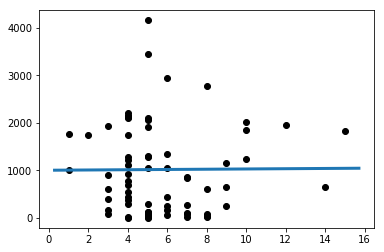

In [8]:
import matplotlib.pyplot as plt
import numpy as np

plt.scatter(upsid_ejectives.ejectives, upsid_ejectives.elevation, color='black')
axes = plt.gca()
x_vals = np.array(axes.get_xlim())
y_vals = regr.intercept + regr.slope*x_vals 
plt.plot(x_vals, y_vals, linewidth=3)

### Мимо
Попробуем с нулями

In [9]:
regr = linregress(upsid_ejectives_with_zeros.ejectives, upsid_ejectives_with_zeros.elevation)
regr

LinregressResult(slope=62.42395995734491, intercept=590.3441943607054, rvalue=0.19089712966672495, pvalue=4.496408159235472e-05, stderr=15.148434088478778)

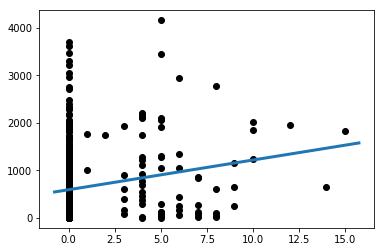

In [10]:
plt.scatter(upsid_ejectives_with_zeros.ejectives, upsid_ejectives_with_zeros.elevation, color='black')
axes = plt.gca()
x_vals = np.array(axes.get_xlim())
y_vals = regr.intercept + regr.slope*x_vals 
plt.plot(x_vals, y_vals, linewidth=3)

## 3. Хи-квадрат
Разделим языки на те, которые выше 1500 и прочие

In [11]:
from scipy.stats import chi2_contingency

upsid_higher = upsid_ejectives_with_zeros[upsid_ejectives_with_zeros.elevation > 1500]
upsid_higher = [len(upsid_higher[upsid_higher.ejectives > 0]), len(upsid_higher[upsid_higher.ejectives == 0])]
#Нормализуем к единице
#upsid_higher = [float(i)/max(upsid_higher) for i in upsid_higher]

upsid_lower = upsid_ejectives_with_zeros[upsid_ejectives_with_zeros.elevation <= 1500]
upsid_lower = [len(upsid_lower[upsid_lower.ejectives > 0]), len(upsid_lower[upsid_lower.ejectives == 0])]
#upsid_lower = [float(i)/max(upsid_lower) for i in upsid_lower]

upsid_all = [upsid_higher, upsid_lower]
chi = chi2_contingency(upsid_all)
'P-value: %.011f' % chi[1]

'P-value: 0.00003292168'